In [2]:
# !pip install 'transformers[torch]'
# !pip install pytorch-transformers
# !pip install tensorboardX

In [3]:
from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
# from transformers import get_linear_schedule_with_warmup
# from transformers.optimization import AdamW
from sys import platform
import re
from pathlib import Path

## Set up GPU

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [6]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 23.5 MB/s eta 0:00:00


In [7]:
from datasets import load_dataset

dataset = load_dataset("sst2")

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset sst2 downloaded and prepared to /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

In [10]:
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()
val_df = dataset['validation'].to_pandas()


In [15]:
home = Path('/content/gdrive/MyDrive/Columbia/RobustStatistics/Sentiment-Analysis-IF/')
data_path = home / 'data'


In [16]:
train_df.to_csv(home/ 'data' / 'train.csv')
test_df.to_csv(home / 'data' / 'test.csv')
val_df.to_csv(home / 'data' / 'val.csv')


In [ ]:
files = ['train.tsv', 'test.tsv', 'dev.tsv']

for f in files:
  df = pd.read_csv(data_path / f, sep='\t', header=None, names=['target', 'text'])
  print(f"{f}: {len(df)}")


train.tsv: 6920
test.tsv: 1821
dev.tsv: 872


In [ ]:
df = pd.read_csv(data_path / 'test.tsv', sep='\t', header=None, names=['target', 'text'])
df.head()

,target,text
0,0,"no movement , no yuks , not much of anything ."
1,0,"a gob of drivel so sickly sweet , even the eag..."
2,0,"gangs of new york is an unapologetic mess , wh..."
3,0,"we never really feel involved with the story ,..."
4,1,this is one of polanski 's best films .


In [1]:
df.iloc[2]

NameError: ignored

## Download Dataset

In [ ]:
# Download data
import requests
request = requests.get("https://drive.google.com/uc?export=download&id=1wHt8PsMLsfX5yNSqrt2fSTcb8LEiclcf")
with open("data.zip", "wb") as file:
    file.write(request.content)

# Unzip data
import zipfile
with zipfile.ZipFile('data.zip') as zip:
    zip.extractall('data')

## Load Train Data

In [ ]:
 # Load data and set labels
data_complaint = pd.read_csv('data/complaint1700.csv')
data_complaint['label'] = 0
data_non_complaint = pd.read_csv('data/noncomplaint1700.csv')
data_non_complaint['label'] = 1

# Concatenate complaining and non-complaining data
data = pd.concat([data_complaint, data_non_complaint], axis=0).reset_index(drop=True)

# Drop 'airline' column
data.drop(['airline'], inplace=True, axis=1)

# Display 5 random samples
data.sample(5)

,id,tweet,label
2536,78076,That annoying moment when you realize 2 hours ...,1
2252,47427,I find it ironic that we arrived at gate L8. B...,1
2449,70121,@AmericanAir In need of a press comment from y...,1
1033,128129,@DeltaAssist on hold for an hour and a half to...,0
1850,17405,"@Goldust @DeltaAssist Dustin, Peep from your...",1


In [ ]:
from sklearn.model_selection import train_test_split

# Create train tests split
X = data.tweet.values
y = data.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

## Load Test Data

In [ ]:
# Load test data
test_data = pd.read_csv('data/test_data.csv')

# Keep important columns
test_data = test_data[['id', 'tweet']]

# Display 5 samples from the test data
test_data.sample(5)

,id,tweet
2878,109684,@JetBlue delayed on Tarmac bc of snow @BostonL...
2731,104611,@AmericanAir your customer service needs some ...
3513,133002,@AmericanAir I hope so. I still don't have it....
2052,79412,@DeltaAssist We have our soldiers on flight DA...
7,287,"Rudest, most condescending customer service re..."


In [ ]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 5.01 s, sys: 688 ms, total: 5.7 s
Wall time: 5.8 s


Best alpha:  1.3


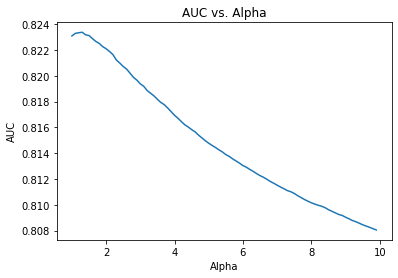

In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()


res = pd.Series(data=[get_auc_CV(MultinomialNB(alpha=i)) for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()